In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
            print(os.listdir("/kaggle/input/iitunet50/modelcheck.h5"))

# Any results you write to the current directory are saved as output.

IndentationError: unexpected indent (<ipython-input-1-e8cb81178ec3>, line 12)

In [2]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [3]:
width = 128
height = 128
channel = 3
train_path = '/kaggle/input/iittest/train_data/data/raw/'
train_mask_path = '/kaggle/input/iittest/train_data/data/gt/'
test_path = '/kaggle/input/iittest/test_data/test_raw/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 78
random.seed = seed
np.random.seed = seed

train_names = next(os.walk(train_path))[2]
test_names = next(os.walk(test_path))[2]
X_train = np.zeros((len(train_names), height, width, channel), dtype=np.uint8)
Y_train = np.zeros((len(train_names), height, width, 1), dtype=np.bool)
print('TRAIN')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_names), total=len(train_names)):
    path = train_path 
    img = imread(path  + id_ )[:,:,:channel]
    img = resize(img, (height, width), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((height, width, 1), dtype=np.bool)
    mask_ = imread(train_mask_path + id_ )
    mask_ = np.expand_dims(resize(mask_, (height, width), mode='constant', 
                                      preserve_range=True), axis=-1)
    Y_train[n] = mask_

X_test = np.zeros((len(test_names), height, width, channel), dtype=np.uint8)
sizes_test = []
print('TEST')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_names), total=len(test_names)):
    path = test_path 
    img = imread(path  + id_ )[:,:,:channel]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (height, width), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

TRAIN


100%|██████████| 590/590 [00:16<00:00, 35.28it/s]

TEST



100%|██████████| 80/80 [00:01<00:00, 49.36it/s]

Done!


In [4]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [5]:
# Predict on train, val and test
model = load_model('/kaggle/input/iitunet50/modelcheck.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
80/80 [==============================] - 0s 1ms/step


In [6]:
for i in preds_test_upsampled:
    print(np.array(i).shape)
    

(256, 256)
(360, 360)
(256, 256)
(256, 256)
(256, 320)
(360, 360)
(360, 360)
(256, 320)
(256, 256)
(256, 256)
(360, 360)
(1024, 1024)
(256, 320)
(256, 256)
(520, 696)
(256, 256)
(256, 256)
(256, 320)
(256, 256)
(360, 360)
(256, 256)
(520, 696)
(360, 360)
(256, 256)
(520, 696)
(256, 256)
(256, 256)
(512, 640)
(256, 256)
(360, 360)
(520, 696)
(256, 320)
(256, 256)
(520, 696)
(360, 360)
(256, 256)
(360, 360)
(256, 256)
(520, 696)
(256, 256)
(1024, 1024)
(256, 320)
(256, 256)
(256, 320)
(256, 320)
(256, 256)
(256, 256)
(256, 320)
(360, 360)
(256, 256)
(512, 640)
(256, 256)
(256, 256)
(520, 696)
(256, 256)
(520, 696)
(256, 256)
(256, 256)
(520, 696)
(256, 256)
(360, 360)
(256, 256)
(520, 696)
(256, 256)
(256, 256)
(256, 256)
(520, 696)
(360, 360)
(256, 256)
(360, 360)
(256, 256)
(520, 696)
(256, 320)
(256, 256)
(360, 360)
(256, 256)
(256, 320)
(360, 360)
(360, 360)
(256, 256)


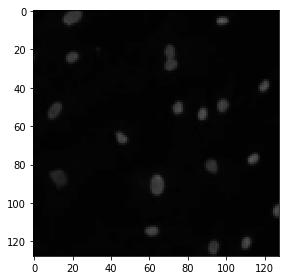

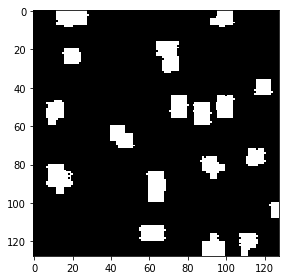

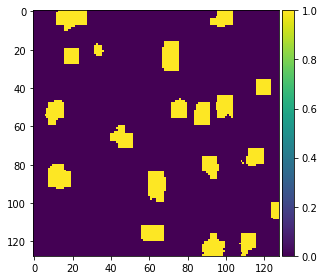

In [7]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [8]:
import scipy.misc


In [9]:
!mkdir outp

In [10]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_names):
    print(id_)
    #     rle = list(prob_to_rles(preds_test_upsampled[n]))
#     rles.extend(rle)
#     new_test_ids.extend([id_] * len(rle))
    scipy.misc.toimage(preds_test_upsampled[n]).save('outp/'+id_)

zbnowxrluhyfopgqemwk.jpg
xkrthiidzdormknuowqh.jpg
xixddbkssvvaenavsinc.jpg
zdutfogwcypxnotmddue.jpg
yadtwvvdfhkmcygocojo.jpg
xsixnflpmphvsxjoilal.jpg
zdayadxvdebajoajuxyn.jpg
xwfbirtwwgwczvjbxdej.jpg
xukgfqcvrnlunyultuin.jpg
znlohahjgyqeaarawntu.jpg
zbiymafariwegbjfthjm.jpg
yfwrsixfukpkhszoxait.jpg
zmtlahrwnzbnrlpnxrvu.jpg
yeiyjuggmspdjwwtqecg.jpg
xqhrvhjbyqauvcpgddif.jpg
znutoceinfnvnznzenkc.jpg
xkwnlyabivdnogjvfmvy.jpg
xryjestdcyexzbyejkpd.jpg
zgfczxnbokwllyxricqj.jpg
yytclmazzgmblmdrhfna.jpg
yddvkjhprdpkqziuwazl.jpg
zgcgzdtglcwppmqaojoy.jpg
znevflexlhvuzuxjzdwu.jpg
xqjpbazxvoajbbauswpt.jpg
xtyjpvjalgwopxcjuvyj.jpg
zgwyxmwghotwnjpvreas.jpg
xvlxkykdvupwbwkyovsz.jpg
xwemfxvgtebcufplvfgl.jpg
yivbjiqpupqnllvzvpbi.jpg
zlskzksklyrqzqousokk.jpg
zvbehepfoibdistyoopk.jpg
zqhqlpqocansetqmleuq.jpg
zlfsramhxifjrdtabjjm.jpg
xmjesioderxukfvrrypg.jpg
xkjmofhvtqgnrcqmfcjg.jpg
xoobkbhbhjigycazfepj.jpg
zcvkniidiamdjekambkf.jpg
xotfgjqilopziozwsqml.jpg
yusdjsztxuwsdkppntqt.jpg
yrgasbsiqakudllstqxz.jpg


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


znxerdutiwemugwoehlg.jpg
zukghlfdbqzhzbdfwxqq.jpg
xyurmiicrgtxlkwfmhln.jpg
xzvbhrxklpauagpzjfvr.jpg
zheenfrdiqilpwfxpixw.jpg
yopsevqvkaeacdlduffy.jpg
zxlirzdcmmrgjzqbfqip.jpg
xfcmwczpgkudxqnitlyx.jpg
xspjtleectgdmavgmcbx.jpg
ywuowrlwprjegmpzisew.jpg
xwprczlgrojuwkrvfegj.jpg
yygbtnbcfuvuzyddbkks.jpg
xdywzbdsxlcikzrilhky.jpg
xgrjqrerkblzwckyuzsj.jpg
ytpnvwpiryxhuhewvbas.jpg
znojcfpcmrrzcfnydwxm.jpg
yybwrmvkbankhhxhluwa.jpg
xkveseaxhnbozckaxfgt.jpg
ypovccalgsjmnlbdjegs.jpg
yrhhnbvmhbiykfmxlqid.jpg
xrszamaqidvouvuxllqb.jpg
xptwwylttpeekyhvveyw.jpg
yddepmeqgneywylyyaxq.jpg
yzjjlmqgmmrmksnwqwom.jpg
znbvorsgjymitomvqvtb.jpg


In [11]:
!ls outp

xdywzbdsxlcikzrilhky.jpg  xzkiakxzrxoievvylyqw.jpg  zbnowxrluhyfopgqemwk.jpg
xfcmwczpgkudxqnitlyx.jpg  xzvbhrxklpauagpzjfvr.jpg  zcvkniidiamdjekambkf.jpg
xgrjqrerkblzwckyuzsj.jpg  yadtwvvdfhkmcygocojo.jpg  zdayadxvdebajoajuxyn.jpg
xixddbkssvvaenavsinc.jpg  ydbnadfmestmqgrewhqt.jpg  zdutfogwcypxnotmddue.jpg
xjbvcruwvsreavtubrxc.jpg  yddepmeqgneywylyyaxq.jpg  zgcgzdtglcwppmqaojoy.jpg
xkjmofhvtqgnrcqmfcjg.jpg  yddvkjhprdpkqziuwazl.jpg  zgfczxnbokwllyxricqj.jpg
xkrthiidzdormknuowqh.jpg  ydtemuyufjmbnaktbzga.jpg  zgwyxmwghotwnjpvreas.jpg
xkveseaxhnbozckaxfgt.jpg  yeiyjuggmspdjwwtqecg.jpg  zheenfrdiqilpwfxpixw.jpg
xkwnlyabivdnogjvfmvy.jpg  yfwrsixfukpkhszoxait.jpg  zjyvkxjbriaqvtnxieoe.jpg
xmjesioderxukfvrrypg.jpg  yhktqoijvvcejjqsszbk.jpg  zlfsramhxifjrdtabjjm.jpg
xoobkbhbhjigycazfepj.jpg  yiqbdgxcyqskqzhiwlio.jpg  zlrjmzmtwzrwjdupkgay.jpg
xotfgjqilopziozwsqml.jpg  yivbjiqpupqnllvzvpbi.jpg  zlskzksklyrqzqousokk.jpg
xptwwylttpeekyhvveyw.jpg  ymsembkrjvwslnqusxhl.jpg  zmtlahrwnzbnrlpnxrvu.jpg

In [12]:
import os
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk('outp/'):
        for file in files:
            ziph.write(os.path.join(root, file))

zipf = zipfile.ZipFile('outp.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('tmp/', zipf)
zipf.close()

In [13]:
import shutil
shutil.make_archive('outpu', 'zip', 'outp/')

'/kaggle/working/outpu.zip'

In [14]:
!ls

__notebook__.ipynb  __output__.json  outp  outp.zip  outpu.zip


In [15]:
# %pylab inline
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# img=mpimg.imread('xwfbirtwwgwczvjbxdej.jpg')
# print(img.shape)
# imgplot = plt.imshow(img, cmap='gray', vmin=0, vmax=255)
# plt.show()